In [1]:
import fileprocessing
import multianalysis
import matplotlib.pyplot as plt
import cooltools
import cooltools.eigdecomp as eigdecomp
import numpy as np
from importlib import reload
import HMMC
import coolplots
import badtools
import numutils
from multiprocessing import Pool
import matplotlib.gridspec as gridspec
import itertools
import triangular

In [2]:
cooldir = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results'

In [3]:
cools = fileprocessing.get_files(cooldir)

In [4]:
df = fileprocessing.cools_df(cools, resolution = 100000)
df

,cell_line,assembly,path,cooler
0,NHEK,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""NHEK_inSitu_MboI.hg19.mapq_30.1000.mc..."
1,IMR90,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""IMR90_inSitu_MboI.hg19.mapq_30.1000.m..."
2,K562,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""K562_inSitu_MboI.hg19.mapq_30.1000.mc..."
3,HUVEC,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""HUVEC_inSitu_MboI.hg19.mapq_30.1000.m..."
4,HMEC,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""HMEC_inSitu_MboI.hg19.mapq_30.1000.mc..."
5,KBM7,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""KBM7_inSitu_MboI.hg19.mapq_30.1000.mc..."
6,GM12878,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""GM12878_inSitu_MboI.hg19.mapq_30.1000..."


In [5]:
genecov_dict = fileprocessing.get_genecov(df)

In [6]:
vals, tracks = multianalysis.get_eigs(df, genecov_dict, n = 3)

In [7]:
with Pool(processes=len(tracks)) as pool:
    hmm_tracks = pool.map(HMMC.auto_analyze, tracks)

[ 2. -2.  2. ...  2.  0.  0.]
[ 0.  2.  0. ... -2.  3.  0.]
[ 2. -2.  0. ...  2.  0.  0.]
[ 0.  2. -2. ...  2. -2.  0.]
[ 2. -2.  2. ...  2. -2.  0.]
[ 0.  2. -2. ... -2.  0.  0.]
[ 2. -2.  2. ...  0.  2.  0.]


In [8]:
bed_dir = '/pollard/data/functional_genomics/encode'
beds = fileprocessing.get_files(bed_dir, 'bed.gz')
beds_df = fileprocessing.beds_df(beds)
beds_df.head()

,cell_line,assay,file_format,output_type,assembly,file_status,target,biosample_treatment,lab,replicate,file_name,file_location
0,keratinocyte,ChIP-seq,bed narrowPeak,optimal idr thresholded peaks,GRCh38,released,CTCF,None,"Vishwanath Iyer, UTA","rep1,2",ENCFF028IIR.bed.gz,/pollard/data/functional_genomics/encode/kerat...
1,keratinocyte,ChIP-seq,bed narrowPeak,peaks and background as input for IDR,GRCh38,released,CTCF,None,"Vishwanath Iyer, UTA","rep1,2",ENCFF465MVV.bed.gz,/pollard/data/functional_genomics/encode/kerat...
2,keratinocyte,ChIP-seq,bed narrowPeak,peaks and background as input for IDR,GRCh38,released,CTCF,None,"Vishwanath Iyer, UTA",rep1,ENCFF301UPP.bed.gz,/pollard/data/functional_genomics/encode/kerat...
3,keratinocyte,ChIP-seq,bed narrowPeak,peaks and background as input for IDR,GRCh38,released,CTCF,None,"Vishwanath Iyer, UTA",rep2,ENCFF623KYU.bed.gz,/pollard/data/functional_genomics/encode/kerat...
4,keratinocyte,ChIP-seq,bed narrowPeak,conservative idr thresholded peaks,hg19,released,CTCF,None,"Vishwanath Iyer, UTA","rep1,2",ENCFF226MQR.bed.gz,/pollard/data/functional_genomics/encode/kerat...


In [9]:
def get_chips(beds_df, cell_line, assembly):
    loc = beds_df[( beds_df.cell_line == cell_line)& 
                  (beds_df.assembly == assembly) &
                  (beds_df.output_type == 'optimal idr thresholded peaks') &
                  (beds_df.replicate == 'rep1,2')
                 ]
    loc = loc.reset_index(drop = True)
    return loc

def run_process(f, collection):
    
    try:
        with Pool(processes=30) as pool:
            r = pool.starmap(f, collection)
            print('Succesful')
        return r
    except:
        print('Error in collection')
        return [None]

def mask_signal(df, sig_target, sig_rule):
    '''
        df: pandas dataframe
        sig_target: column name of which desired signal is to be masked
        sig_rule: column name of the signal that is set to be used as the masking rule
    '''
    mask = df[sig_rule] == df[sig_rule]
    
    return df[mask][sig_target].values

In [10]:
results = [run_process(badtools.chip_intersect, zip(itertools.repeat(hmm_tracks[i]), get_chips(beds_df, df.iloc[i].cell_line, df.iloc[i].assembly).file_location.values.tolist()))
           for  i in range(len(df))]

Succesful
Succesful
Succesful
Succesful
Succesful
Succesful
Succesful


In [11]:
for i in range(len(results)):
    print(i , len(results[i]), df.cell_line[i])

0 0 NHEK
1 8 IMR90
2 316 K562
3 4 HUVEC
4 0 HMEC
5 0 KBM7
6 121 GM12878


In [65]:
k = 6 #Let's only do GM12878
chip_df = get_chips(beds_df, df.iloc[k].cell_line, df.iloc[k].assembly)
x = mask_signal(hmm_tracks[k], 'HMM3', 'E1')
h = np.array([0, 1, 0])
index_dict = triangular.find_pattern(x, h, depth = 22)

In [97]:
reload(triangular)

<module 'triangular' from '/pollard/home/lchumpitaz/Hi-C/testing/triangular.py'>

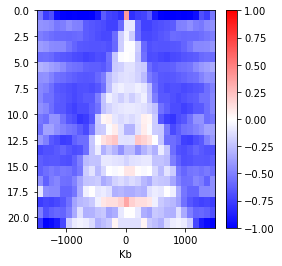

In [98]:
triangular.plot_triangle(index_dict, mask_signal(hmm_tracks[k], 'E1', 'E1'),
                         figsize = (4, 4),
                         win_size = 15, average = True)

In [103]:
index_dict

{1: [array([27587]), array([27587])],
 2: [array([ 8189, 11236, 12821, 13185, 13323, 16992, 18573, 20407, 21345,
         21652]),
  array([ 8189, 11236, 12821, 13185, 13323, 16992, 18573, 20407, 21345,
         21652])],
 3: [array([ 2245,  4191,  4769,  5391,  6227,  6403, 10768, 11420, 11484,
         13992, 14846, 14851, 14901, 15033, 15048, 15056, 15862, 16188,
         16669, 16857, 17162, 18901, 19473, 20720, 23499, 25096, 25892]),
  array([ 2245,  4191,  4769,  5391,  6227,  6403, 10768, 11420, 11484,
         13992, 14846, 14851, 14901, 15033, 15048, 15056, 15862, 16188,
         16669, 16857, 17162, 18901, 19473, 20720, 23499, 25096, 25892])],
 4: [array([  684,  1357,  2179,  2359,  4712,  4806,  5298,  6386,  9234,
         10957, 17078, 19065, 19695, 20842, 23874, 23953, 24734, 25019]),
  array([  684,  1357,  2179,  2359,  4712,  4806,  5298,  6386,  9234,
         10957, 17078, 19065, 19695, 20842, 23874, 23953, 24734, 25019])],
 5: [array([10969, 11598, 11778, 13915, 14

In [102]:
triangular.get_triangle(index_dict,  
             mask_signal(results[k][i], 'signalValue', 'E1'), 
             win_size = 15, average = True, fold = True).shape

(21, 31)

In [93]:
fig_list = list()
for i in range(len(chip_df)):
    
    fig_list.append(triangular.plot_triangle(index_dict,
                    mask_signal(results[k][i], 'signalValue', 'E1'), 
                         figsize = (4, 4),
                         win_size = 15, average = True, fold = True, 
                         title = chip_df.target.iloc[i]))

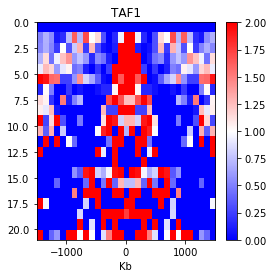

In [104]:
fig_list[0]